# Homework 2 Part 4: Attention-based classification

This last part of homework 2 will have you _using_ the vectors we learned from your word2vec implementation to do classification. You should complete the initial word2vec part before before starting on this.

Broadly, this last part of the homework consists of a few major steps:
1. Load in the data, word vectors, and word-indexing
2. Define the attention-based classification network
3. Train your model at least one epoch (2+ is recommended though).
4. Perform exploratory analyses on attention
5. Test the effects of freezing the pre-trained word vectors (see homework PDF for details)

After Step 2, you should be able to train your classifier implementation on a small percent of the dataset and verify that it's learning correctly. **Please note that this list is a general sketch and the homework PDF has the full list/description of to-dos and all your deliverables.**


### Estimated performance times

We designed this homework to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this homework can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation for longer-running or data-intensive pieces of the homework. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading data, tokenizing, and converting to ids: ~20 seconds
* Training one epoch: ~18 minutes
* Training one epoch using frozen embeddings: ~3 minutes
* Evaluating on dev/test set: ~5 seconds

In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim

import pandas as pd
import pickle

import wandb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# Attention plotting
import matplotlib.pyplot as plt

import pickle

# Load in the necessary parameters from the word2vec code

In [15]:
# Load the word-to-index mapping we used for word2vec and use the same type
# of tokenizer. We'll need to use this to tokenize in the same way and keep 
# the same word-to-id mapping


tokenizer = RegexpTokenizer(r'\w+')

with open('128_y_mod_idx2word', 'rb') as f:
    index_to_word = pickle.load(f)
    
with open('128_y_mod_word2idx', 'rb') as f:
    word_to_index = pickle.load(f)


# Define the Classifier Model

Just like we did for word2vec, let's define a PyTorch `nn.Module` class here that will contain our classifier.

In [31]:
class DocumentAttentionClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, num_heads, embeddings_fname):
        '''
        Creates the new classifier model. embeddings_fname is a string containing the
        filename with the saved pytorch parameters (the state dict) for the Embedding
        object that should be used to initialize this class's word Embedding parameters
        '''
        super(DocumentAttentionClassifier, self).__init__()
        
        torch.manual_seed(1234)
        
        # Save the input arguments to the state
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.embeddings_fname = embeddings_fname
        
        
        
        # Create the Embedding object that will hold our word embeddings that we
        # learned in word2vec. This embedding object should have the same size
        # as what we learned before. However, we don't to start from scratch! 
        # Once created, load the saved (word2vec-based) parameters into the object
        # using load_state_dict.
        state_dict = torch.load(embeddings_fname, map_location=torch.device('cpu'))

        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.embeddings.weight.data = state_dict['target_embeddings.weight']
        
       
        
        

        # Define the attention heads. You have two options:
        # 
        # 1) the worse way to implement this is to define your heads using an Embedding
        #    and then access them individually later in forward(). This will be slower
        #    but will probably still work 
        #
        # 2) the ideal way is to think of your attention heads as rows in a matrix--
        #    just like we do for word2vec. While this is kind of the same as how
        #    we represent things like in an Embedding, the key difference is that we
        #    can now use **matrix operations** to calculate the different r and a
        #    vectors, which will be much faster (and less code). To do this, you'll
        #    need to represent the attention heads as a Tensor directly (not a layer)
        #    and make sure pytorch runs gradient descent on these parameters.
        #
        #  It's up to you which to use, but try option 2 first and see what you do 
        #  in the forward() function
        self.attention_heads = nn.Parameter(torch.randn(num_heads, embedding_size))
        
        
        # Define the output layer
        
        # Define the layer that goes from the concatenated attention heads' outputs
        # to the single output value. We'll push this output value through the sigmoid
        # to get our prediction
   
        #self.output_layer = nn.Linear(self.vocab_size * self.num_heads, 1) 
        self.output_layer = nn.Linear(num_heads * embedding_size, 1)


        pass
    

    def forward(self, word_ids):
        
        word_embeds = self.embeddings(word_ids)  

        #attention_heads_expanded = self.attention_heads.unsqueeze(0).expand(word_embeds.size(0), 1, -1)
        #attention_heads_expanded = self.attention_heads.expand(word_embeds.size(0), 1, -1)

        attention_heads_expanded = self.attention_heads.unsqueeze(0).expand(word_embeds.size(0), -1, -1)

        r = torch.bmm(attention_heads_expanded, word_embeds.transpose(1, 2)) 
        a = F.softmax(r, dim=2)

        weighted_sum = torch.bmm(a, word_embeds)  
        concatenated = weighted_sum.view(word_embeds.size(0), -1)  
        output = torch.sigmoid(self.output_layer(concatenated))

        return output,a




dataset = DataLoader(train_list, batch_size=1)
model = DocumentAttentionClassifier(len(word_to_index), 50, 4, "128_y_mod.pth")

# model.train()
# for index, (token_ids, labels) in enumerate(dataset):
#     if index < 10:  
#         output = model.forward(token_ids)
#         print(output)
  
#     else:
#         break  
# #print("Done")

# Load in the datasets 

You can keep these as pandas data frames.

In [17]:
sent_train_df = pd.read_csv("sentiment.train.csv")
sent_dev_df = pd.read_csv("sentiment.dev.csv")
sent_test_df = pd.read_csv("sentiment.test.csv")

file_dict = {
    'train':sent_train_df, 
    'dev':sent_dev_df,
    'test':sent_test_df
}

Convert each dataset into a list of tuples of the form `([word-ids,...], label)`. Both the word ids and the label should be numpy arrays so they will get converted into Tensors by our data loader. Note that you did something very similar for creating the word2vec training data. This process will require tokenizing the data in the same way as you did for word2vec and using the same word-to-id mapping (both of which you loaded/created above).

In [18]:
train_list = []
dev_list = []
test_list = []

words = set(list(word_to_index.keys()))

print("TRAIN DF")
for idx, row in sent_train_df.iterrows():
    tokens = tokenizer.tokenize(row['text'])
    token_ids = []
    label = row['label']
    for token in tokens:
        if token in words:
            token_ids.append(word_to_index[token])
        else:
            pass
    tupple = (np.array(token_ids), np.array(label))
    train_list.append(tupple)
    
print("DEV DF")
for idx, row in sent_dev_df.iterrows():
    tokens = tokenizer.tokenize(row['text'])
    token_ids = []
    label = row['label']
    for token in tokens:
        if token in words:
            token_ids.append(word_to_index[token])
        else:
            pass
    tupple = (np.array(token_ids), np.array(label))
    dev_list.append(tupple)
    
print("TEST DF") 
for idx, row in sent_test_df.iterrows():
    tokens = tokenizer.tokenize(row['text'])
    token_ids = []
    for token in tokens:
        if token in words:
            token_ids.append(word_to_index[token])
        else:
            pass
    tupple = (np.array(token_ids))
    test_list.append(tupple)
        

TRAIN DF
DEV DF
TEST DF


If this worked you should see XXXX train, XXXX dev, and XXX test instances.

In [7]:
len(train_list), len(dev_list), len(test_list)

(160000, 20000, 20000)

# Build the code training loop

We'll evaluate periodically so before we start training, let's define a function that takes in some evaluation data (e.g., the dev or test sets) and computes the F1 score on that data. 

In [8]:
from sklearn.metrics import f1_score

def run_eval(model, eval_data):
    '''
    Scores the model on the evaluation data and returns the F1
    '''

   # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = 'cpu'
    data_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=True)
    optimizer = optimizer_choice(lr=learning_rate, params=model.parameters())
    loss_fn = torch.nn.BCELoss()
    
    actual_labels = []
    predicted_labels = []
    
    for index, (token_ids, labels) in enumerate(tqdm(data_loader)):
        
        with torch.no_grad():

            token_ids = token_ids.to(device)
            labels = labels.float().to(device)

            output, attn = model(token_ids)
            output = output[0]
            
            if output > 0.5:
                pred = 1
            else:
                pred = 0
                
            loss = loss_fn(output,labels)

            actual_labels.append(int(labels))
            predicted_labels.append(int(pred))

    return f1_score(actual_labels, predicted_labels)



Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The training code will look surprisingly similar to your word2vec code. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. **see below:** Initializes Weights & Biases and periodically write our running-sum of the loss 
5. Train your model 

For step 4, in addition to writing the loss, you should write the F1 score on the dev set to the `wandb` as well, using the specified number of steps.

**NOTE:** In this training, you'll use a batch size of 1, which will make your life _much_ simpler.

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import time
import os

##########################
# CHECK DEVICE
##########################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")

##########################
# PARAMETERS
##########################
early_stop = False
batch_size = 1
learning_rate = 5e-5  
window_size = 2  
epochs = 1
optimizer_choice = AdamW


##########################
# MODEL
##########################

model = DocumentAttentionClassifier(len(word_to_index), 50, 4, "128_y_mod.pth")
data_loader = DataLoader(train_list, batch_size=batch_size, shuffle=True)
optimizer = optimizer_choice(lr=learning_rate, params=model.parameters())
loss_fn = torch.nn.BCELoss()


##########################
# TRAINING
##########################

# LOSS STUFF

actual_labels = []
predicted_labels = []

wandb.init(project='attn2', name='attn2')
start_time = time.time()
print("start time", start_time)
loss_data = []
total_step = 0
loss_sum = 0
model.train()
for epoch in range(epochs):
    epoch_step = 0
    for index, (token_ids, labels) in enumerate(tqdm(data_loader)):
        
        
        token_ids = token_ids.to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()

        output, attn = model(token_ids)
        output = output[0]
        #print("output shape", output.shape)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        total_step += 1
        epoch_step +=1 
        #print(loss.item())
        
        actual_labels.append(labels)
        predicted_labels.append(labels)

        
        loss_sum += loss.item()
        
        
        if (index) % 5000 == 0:
            f1 = run_eval(model, dev_list)
            wandb.log({"f1": f1})

        if (index) % 500 == 0:
            wandb.log({"loss last 500 steps": loss_sum})
            loss_data.append({'epoch':epoch, 'loss':loss.item(), 'epoch_step':epoch_step, 'total_step':total_step})
            loss_sum = 0
        if early_stop:
            if total_step > early_stop:
                print("BREAKING")
                break
print("DONE")
end_time = time.time()
print("end time", end_time)


######## d##################
# PLOTS
##########################
model.eval()
#loss_df = pd.DataFrame(loss_data)
#sns.lineplot(data=loss_df, x='total_step', y='loss')

Using device: cpu


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss last 500 steps,▄▃▂▄▂▄▂▃▂▆▅█▂▁▄▄▄▄▄▄▆▂▃▄▄▁▃▄▄▃▅▄▄▄▆▃▃▁▃▃
f1,0.618
loss last 500 steps,347.07711


start time 1709426307.257409


  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

DONE
end time 1709426961.6168199


DocumentAttentionClassifier(
  (embeddings): Embedding(35193, 50)
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)

# Test Set Prediction

In [10]:
data_loader = DataLoader(test_list, batch_size=1, shuffle=False)
optimizer = optimizer_choice(lr=learning_rate, params=model.parameters())
loss_fn = torch.nn.BCELoss()

preds = []

for index, (token_ids) in enumerate(tqdm(data_loader)):

    with torch.no_grad():

        token_ids = token_ids.to(device)

        output = model(token_ids)[0]

        if output > 0.5:
            pred = 1
        else:
            pred = 0
        preds.append(pred)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [11]:
predy = pd.DataFrame(preds)
predy.columns = ['pred']
predy['inst_id'] = sent_test_df['inst_id'].to_list()
predy['pred'] = predy['pred'].apply(lambda x: int(x))
predy
predy.to_csv("attn_preds.csv", index=False)

In [13]:
print(predy.head())

   pred  inst_id
0     0        0
1     1        1
2     0        2
3     1        3
4     0        4


# Frozen Model

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import time
import os

class FrozenAttn(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, num_heads, embeddings_fname):
        '''
        Creates the new classifier model. embeddings_fname is a string containing the
        filename with the saved pytorch parameters (the state dict) for the Embedding
        object that should be used to initialize this class's word Embedding parameters
        '''
        super(FrozenAttn, self).__init__()
        
        torch.manual_seed(1234)
        
        # Save the input arguments to the state
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.embeddings_fname = embeddings_fname
        
        
        
        # Create the Embedding object that will hold our word embeddings that we
        # learned in word2vec. This embedding object should have the same size
        # as what we learned before. However, we don't to start from scratch! 
        # Once created, load the saved (word2vec-based) parameters into the object
        # using load_state_dict.
        state_dict = torch.load(embeddings_fname, map_location=torch.device('cpu'))

        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.embeddings.weight.data = state_dict['target_embeddings.weight']
        
        # frozen line
        self.embeddings.weight.requires_grad = False

       
        
        

        # Define the attention heads. You have two options:
        # 
        # 1) the worse way to implement this is to define your heads using an Embedding
        #    and then access them individually later in forward(). This will be slower
        #    but will probably still work 
        #
        # 2) the ideal way is to think of your attention heads as rows in a matrix--
        #    just like we do for word2vec. While this is kind of the same as how
        #    we represent things like in an Embedding, the key difference is that we
        #    can now use **matrix operations** to calculate the different r and a
        #    vectors, which will be much faster (and less code). To do this, you'll
        #    need to represent the attention heads as a Tensor directly (not a layer)
        #    and make sure pytorch runs gradient descent on these parameters.
        #
        #  It's up to you which to use, but try option 2 first and see what you do 
        #  in the forward() function
        self.attention_heads = nn.Parameter(torch.randn(num_heads, embedding_size), requires_grad=True)
        
        
        # Define the output layer
        
        # Define the layer that goes from the concatenated attention heads' outputs
        # to the single output value. We'll push this output value through the sigmoid
        # to get our prediction
   
        #self.output_layer = nn.Linear(self.vocab_size * self.num_heads, 1) 
        self.output_layer = nn.Linear(num_heads * embedding_size, 1)


        pass
    

    def forward(self, word_ids):
        
        word_embeds = self.embeddings(word_ids)  

        #attention_heads_expanded = self.attention_heads.unsqueeze(0).expand(word_embeds.size(0), 1, -1)
        #attention_heads_expanded = self.attention_heads.expand(word_embeds.size(0), 1, -1)

        attention_heads_expanded = self.attention_heads.unsqueeze(0).expand(word_embeds.size(0), -1, -1)

        r = torch.bmm(attention_heads_expanded, word_embeds.transpose(1, 2)) 
        a = F.softmax(r, dim=2)

        weighted_sum = torch.bmm(a, word_embeds)  
        concatenated = weighted_sum.view(word_embeds.size(0), -1)  
        output = torch.sigmoid(self.output_layer(concatenated))

        return output,a




dataset = DataLoader(train_list, batch_size=1)
frozen = FrozenAttn(len(word_to_index), 50, 4, "128_y_mod.pth")




##########################
# CHECK DEVICE
##########################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")

##########################
# PARAMETERS
##########################
early_stop = False
batch_size = 1
learning_rate = 5e-5  
window_size = 2  
epochs = 1
optimizer_choice = AdamW


##########################
# MODEL
##########################

frozen = FrozenAttn(len(word_to_index), 50, 4, "128_y_mod.pth")
data_loader = DataLoader(train_list, batch_size=batch_size, shuffle=True)
optimizer = optimizer_choice(lr=learning_rate, params=frozen.parameters())
loss_fn = torch.nn.BCELoss()


##########################
# TRAINING
##########################

# LOSS STUFF

actual_labels = []
predicted_labels = []

wandb.init(project='frozen3', name='frozen3')
start_time = time.time()
print("start time", start_time)
loss_data = []
total_step = 0
loss_sum = 0
frozen.train()
for epoch in range(epochs):
    epoch_step = 0
    for index, (token_ids, labels) in enumerate(tqdm(data_loader)):
        
        
        token_ids = token_ids.to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()

        output, attn = frozen(token_ids)
        output = output[0]
        #print("output shape", output.shape)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        total_step += 1
        epoch_step +=1 
        #print(loss.item())
        
        actual_labels.append(labels)
        predicted_labels.append(labels)

        
        loss_sum += loss.item()
        
        
        if (index) % 5000 == 0:
            f1 = run_eval(frozen, dev_list)
            wandb.log({"f1": f1})

        if (index) % 500 == 0:
            wandb.log({"loss last 500 steps": loss_sum})
            loss_data.append({'epoch':epoch, 'loss':loss.item(), 'epoch_step':epoch_step, 'total_step':total_step})
            loss_sum = 0
        if early_stop:
            if total_step > early_stop:
                print("BREAKING")
                break
print("DONE")
end_time = time.time()
print("end time", end_time)


######## d##################
# PLOTS
##########################
frozen.eval()
#loss_df = pd.DataFrame(loss_data)
#sns.lineplot(data=loss_df, x='total_step', y='loss')



Using device: cpu


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


f1,██▇▁█
loss last 500 steps,▁██████████████████████████████████▇████
f1,0.6146
loss last 500 steps,323.93188


start time 1709429726.736884


  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

DONE
end time 1709430121.5357087


FrozenAttn(
  (embeddings): Embedding(35193, 50)
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)

# Inspecting what the model learned

In this last bit of the homework you should look at the model's attention weights. We've written a visualization helper function below that will plot the attention weights. You'll need to fill in the `get_label_and_weights` method that uses the model to classify some new text and structures the attention output in a way that's specified. 

**NOTE:** most of the code for `get_label_and_weights` is code you've already written above.

In [268]:
def get_label_and_weights(text):
    '''
    Classifies the text (requires tokenizing, etc.) and returns (1) the classification label, 
    (2) the tokenized words in the model's vocabulary, 
    and (3) the attention weights over the in-vocab tokens as a numpy array. Note that the
    attention weights will be a matrix, depending on how many heads were used in training.
    '''
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    token_ids = [word_to_index[token] for token in tokens if token in word_to_index]
    token_ids_tensor = torch.tensor([token_ids])
    with torch.no_grad():
        yhat, attn = model(token_ids_tensor)
    label = 1 if yhat > 0.5 else 0
    attn = torch.transpose(attn.squeeze(),0,1)

    valid_tokens = [token for token in tokens if token in word_to_index]

    return label, valid_tokens, attn

    


### Helper functions for visualization

In [243]:
def visualize_attention(words, attention_weights):
    '''
    Makes a heatmap figure that visualizes the attention weights for an item.
    Attention weights should be a numpy array that has the shape (num_words, num_heads)
    '''
    fig, ax = plt.subplots() 
    # Rescale image size based on the input length
    fig.set_size_inches((len(words), 4))    
    im = ax.imshow(attention_weights.T)

    head_labels = [ 'head-%d' % h for h in range(attention_weights.shape[1])]
    ax.set_xticks(np.arange(len(words))) # , labels=words)
    ax.set_yticks(np.arange(len(head_labels))) #, labels=head_labels)

    # Rotate the word labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Add the words and axis labels
    ax.set_yticklabels(labels=range(attention_weights.shape[1]), fontsize=16)
    ax.set_ylabel('Attention Head', fontsize=16)
    ax.set_xticklabels(labels=words, fontsize=16)

    # Add a color bar to show probability scaling
    cb = fig.colorbar(im, ax=ax, label='Probability', pad = 0.01)
    cb.ax.tick_params(labelsize=16)
    cb.set_label(label='Probability',size=16)
    fig.tight_layout()
    plt.show()

Example messages to try visualizing.

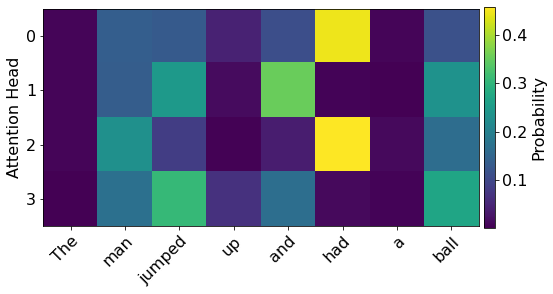

In [267]:
s = 'The man jumped up and had a ball'
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

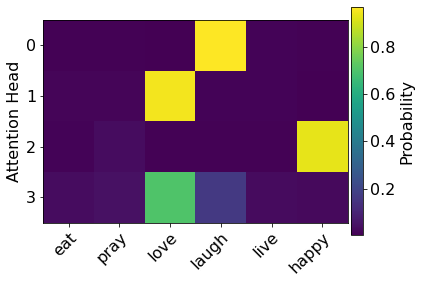

In [269]:
s = 'eat pray love laugh live happy'
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

In [263]:
sent_dev_df['wc'] = sent_dev_df['text'].apply(lambda x: len(x.split()))

samples = sent_dev_df.query("wc<=30").groupby(by=['label']).sample(200, random_state=4).sort_values(by=['wc'])
att_data = []

for idx, row in samples.iterrows():
    text = row['text']
    label = row['label']
    pred, tokens, attn = get_label_and_weights(text)
    att_data.append({'pred':pred, "tokens":tokens, "w":attn, "actual":label})
    acc = 1 if label == pred else 0
    print()
    print(text, label, pred)
    
at_df = pd.DataFrame(att_data)
at_df['acc'] = (at_df['pred'] == at_df['actual']).astype(int)


Nothing special, seen many of these recipes online for free. 0 0

A bit boring, a bit long. Too many sexual scenes. 0 0

Did not have the end notes/references like my previous copy 1 0

More of the same.... very well written holds my interest. 1 1

Not as well written as I hought it would be 0 0

Eye openning. Very inspiring. Makes looking at life very differently. 1 1

As advertised, but not really what I was looking for. 0 0

Like walking through three feet of mud. Slow, arduous, plotless. 0 0

Love Celia Kyle's books, buy it you won't regret it 1 1

Didn't enjoy as much as some of her other books 0 0

Exactly as listed. My granddaughter loves it! Was shipped promptly. 1 1

Not as good as the previous books in the series. 0 0

This stuff is simply amazing...don't let it pollute your mind. 0 1

You would spend a lot for all of the ingredients 0 0

A waste of time if your not a Cubbies Fan 0 0

Not very well written , rather thrashy but very readable. 0 0

he teaches false doctrine ab

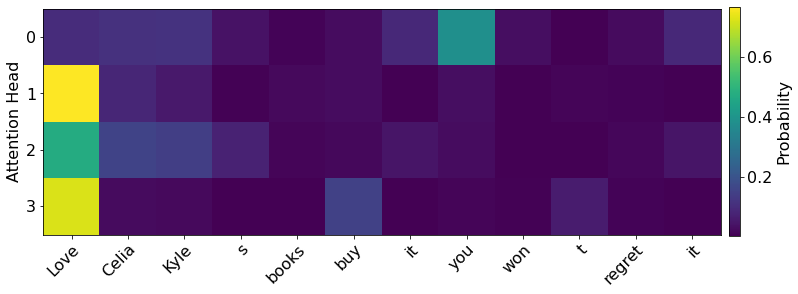

In [272]:
# positive
s = "Love Celia Kyle's books, buy it you won't regret it"
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

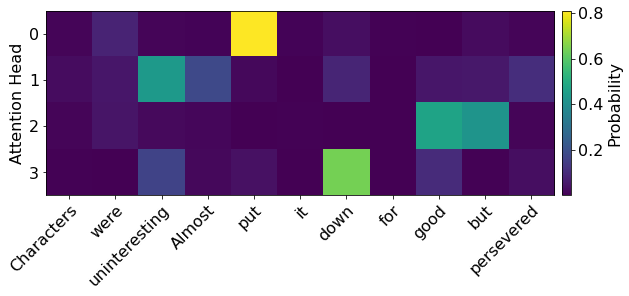

In [273]:
# negative, mispredicted
s = "Characters were uninteresting. Almost put it down for good but persevered"
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

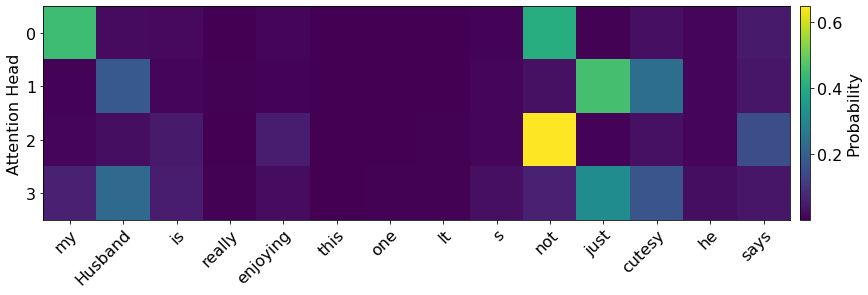

In [278]:
# positive, mispredicted
s = """my Husband is really enjoying this one!!! "It's not just cutesy" he says"""
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

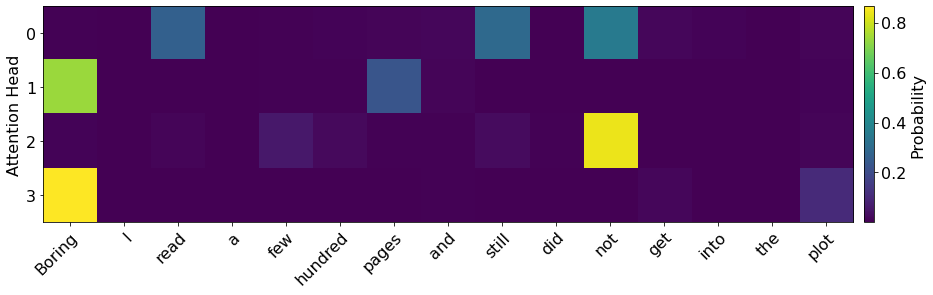

In [277]:
# negative, correct
s = "Boring I read a few hundred pages and still did not get into the plot!!!"
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

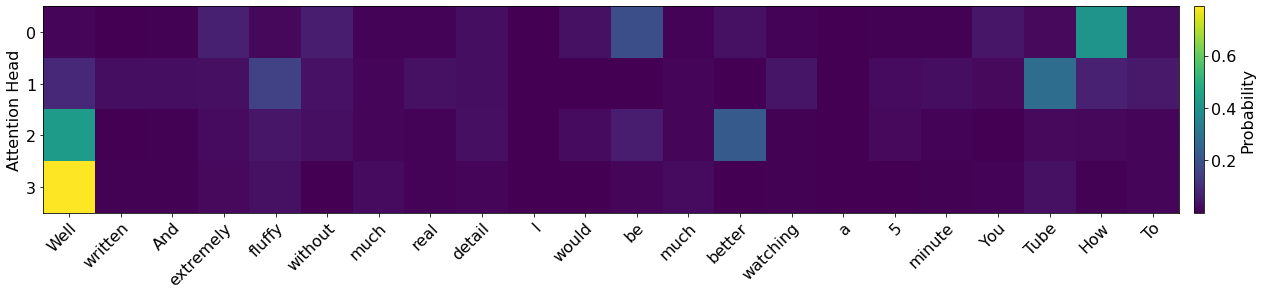

In [280]:


# negative, incorrect
s = """Well written....And extremely fluffy without much real detail. I would be much better watching a 5 minute You Tube "How To..."."""
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

# Optional TODOs:

### How many instances do we need to learn?

Since the word2vec vectors capture word meaning, do we need to see a lot of examples to train an effective classifier? Maybe we can get away with fewer (or not?). Try making a plot that shows the performance of training on 1 epoch with varying numbers of training examples. What if we just had 10 examples? 100? 1000? 

### Make the "important word" vectors learn different attentions

If your attention vectors are learning to look at similar words, we could try to add some structure to how we learn so these vectors become dissimilar. One idea is to penalize the model according to how similar each head's vector is to the others. You could use cosine similarity or MSE or any weighting function. For example, you could add the cosine similarities of each pair to the `loss` so that the model benefits from learning orthoginal or dissimlar vectors. Would this help? 

### Add more layers to the network

This is the second easiest one, but can be fun. What if you add more layers after you aggregate? Does letting the different attention heads' representations interact give better performance? Find out!

### Change the learning rate dynamically

We have a fixed learning rate, but what if we wanted to decrease the learning rate as the model starts to converge? In many cases, this can help the model take smaller but more precise steps towards the best possible parameters. PyTorch supports this with _learning rate schedulers_ that tell pytorch how and when to change the learning rate. See if you can get a better performance using a scheduler!

### Add support for batch sizes > 1

This is non-trivial but will increase training speed _a lot_. The main issue with increasing batch sizes is that our input sequences (the word ids) in a batch will have different lengths. Under the hood, pytorch is turning your code into a series of very fast matrix operations. However, if those matrices suddenly have difference sizes, the math no longer works. As a result developers (like us) have to do a few things:

* We need to _pad_ the sequences with empty values so that all sequences have the same length. You could do this by  adding an extra word ID that is the "empty token" and make sure its values are set to 0 (so it won't interact with anything)

* Set up a collate function in our DataLoader that automatically pads each batch's data based on the longest length in the batch

* At inference time, it's also efficient to mask part of the sequence that's the padded part so we ignore the computations for that part in anything downstream. Depending on how you set it up, you may be able to avoid this step.

If you want to dig into this, you might see some of the documentation around packed and padded sequences in pytorch. You won't need to use these functions but they can provide more context for what's happening and why.


### Add positional information to the word embeddings

Right now our model doesn't know much about which order the words are in. What if we helped the model in this? One way that people have done this is to _add_ some positional embedding to the word embedding, where the positional embedding represents which position in the sequence is in. There are many complicated schemes for this, but one potential idea is to _learn the positional embeddings_. You would keep a separate `Embedding` object for positions with the number of positions up to the length of your longest sequence in the data. Then for the word in the first position, you add `position_embeddings(0)` to it. You can definitely speed that up by passing in a sequence of the positions in the current input and, conveniently, pytorch will let you easily add all the position embeddings to the word embeddings easily (no for loop required).

Will it help here? I have no idea but I'm curious.


**No extra credit is given for these; they're just for folks who want to explore more**